In [2]:
!pip install pandas
!pip install tensorflow
!pip install scikit-learn

In [3]:
from google.colab import drive


In [4]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [5]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as k
import tensorflow.keras.layers as l
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
import os
print(os.getcwd())
print(os.listdir())

/content
['.config', 'drive', 'sample_data']


In [7]:
os.chdir("/content/drive/MyDrive/Colab Notebooks")

In [8]:
final_embed=pd.read_json("final_word_embeddings_clean.json")
final_data=pd.read_json("final_data_clean.json")
y_train=pd.read_csv("y_train.csv")

In [9]:
y_train=y_train["is_sarcastic"] # come to this later on

# Chapter 4


Before we march ahead, we need to have a reality check whether all the words indices that we have in our corpus are the same indices that we have in our word embedding incides.

Let us first do that.

In [10]:
set1_corpus_nos=set(np.unique(final_data.values))

set2_embed_nos=set(final_embed.index)

In [11]:
set2_embed_nos-set1_corpus_nos

{1670,
 2379,
 3000,
 3699,
 3707,
 3726,
 4158,
 4182,
 4271,
 4668,
 5265,
 5600,
 5666,
 5754,
 5775,
 5892,
 5962,
 6224,
 6356,
 6460,
 6912,
 7046,
 7052,
 7149,
 7591,
 7652,
 7684,
 7812,
 8059,
 8138,
 8508,
 8964,
 9092,
 9274,
 9375,
 9542,
 9739,
 9786,
 9914,
 9974,
 9987,
 10122,
 10206,
 10353,
 10459,
 10523,
 10593,
 10640,
 10726,
 10846,
 10920,
 11018,
 11054,
 11106,
 11115,
 11201,
 11287,
 11333,
 11456,
 11526,
 11533,
 11713,
 11736,
 11758,
 11846,
 11932,
 11976,
 11987,
 12063,
 12212,
 12226,
 12383,
 12610,
 12639,
 12696,
 12771,
 12827,
 12940,
 12956,
 13053,
 13109,
 13114,
 13123,
 13285,
 13302,
 13694,
 13723,
 13832,
 13842,
 13884,
 13946,
 13962,
 14274,
 14371,
 14457,
 14482,
 14514,
 14548,
 14599,
 14684,
 14711,
 14739,
 14763,
 14827,
 14849,
 14860,
 14950,
 14969,
 15025,
 15043,
 15083,
 15135,
 15335,
 15376,
 15464,
 15484,
 15499,
 15521,
 15563,
 15695,
 15817,
 15826,
 15883,
 15900,
 16031,
 16082,
 16119,
 16160,
 16269,
 16387,
 

These are the word indices that are in the embeddings that are not in the corpus.



In [12]:
set1_corpus_nos-set2_embed_nos

{400000}

These are the word indices that are in the corpus but are absent in the indices. Both of them needs proper investigation to find it out.


Since we have chopped off our sequence length to just 10 words (which can easily be adjusted for better accuracy), we are bound to miss some words that were in the original sequences but are not in the chopped of sequences. So, its okay. Its not being disturbed here, in case if we want to have longer sequences. So, we are going to leave it as it is.

But the other case of 400000th word index that is missing in the glove vector. What is that word ? If we don't address the issue by updating the number, we are going to face errors in future.

Let us now check the distribution of each of these sets and it might give us a clue as to what that 40000th word is what it might be doing.

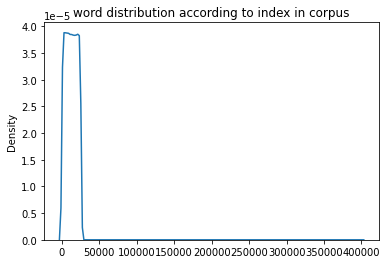

In [13]:
plt.title("word distribution according to index in corpus")
sns.kdeplot(list(set1_corpus_nos))
plt.show()

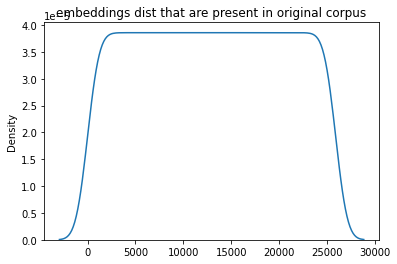

In [14]:
plt.title("embeddings dist that are present in original corpus")
sns.kdeplot(list(set2_embed_nos))
plt.show()

If you carefully observe the difference, the outlier is a loner and completely off. It should be smooth and flat distribution like the one show in the second graph. 


This means that particular word(indicated by the number index) is an anamoly/bug crept in by the code somewhere because of some process (my guess is lemmatization making the column extremely empty, which we have already seen once). Let us check what word that particular single number i.e. 40000 represents. It will be located in our original non cleaned dataframe. We then, based on it, should patch up the code or write an exception/dictionary entry to our embeddings library for that case.

The later is the good one, since this is bound to repeat in unknown dataset if it is repeated now, so we should catch it.

Note that original dataframe, the uncleaned version, is in the variable with the name "final_word_embeddings"

Let us reload original, non-cleaned dataframe again on a temp variable.

In [16]:
final_word_embeddings=pd.read_json("final_word_embeddings.json")

In [17]:
pd.DataFrame(final_word_embeddings.loc[400000]).T

,words,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
400000,unicyclist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Identified the bug**

The Bug here is probaby that it is a one word two word sentence, whose token got chopped off when limited the sequences and based on our decision on that.

**Solution**

Just put in some other value to it that has a similar vector embedding. it seems to occur only once, from the code given below. So, it is safe to replace it with zero. Not just that, we can extend it to simialr concepts too where if the extremely rare occurrence of sometimes is there, we can simply ignore it.


In [18]:
for each in final_data.columns:
    c=final_data[each].max()
    if c>final_embed.shape[0]:
        print(c)
        print(each)

400000
5


So, there is only one entry in fifth column/feature of some sequence in the entire dataframe. That is good. So, we are flagged to go ahead. So, we will use a number that is in the embed vocabulary, but vector hasn't been used because of chopping off. We will randomly place it and check 

In [19]:
final_data.replace(400000,5962,inplace=True)

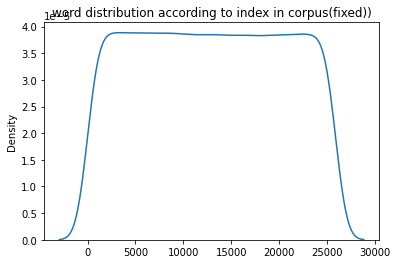

In [20]:
plt.title("word distribution according to index in corpus(fixed))")
sns.kdeplot(list(set(np.unique(final_data.values))))
plt.show()

In [21]:
for each in final_data.columns:
    c=final_data[each].max()
    if c>final_embed.shape[0]:
        print(c)
        print(each)        

Now, you observe that the value is flat distribution and the data is showing no objects/number at all that crept it. So, all our word corpus has one unique word vector associated with it.

In [22]:
final_data

,0,1,2,3,4,5,6,7,8,9
0,64,11298,1244,5504,4695,1376,25791,1757,1802,12973
1,22535,4123,2417,10371,105,3748,298,2142,0,0
2,4472,897,1280,459,1,884,159,3926,658,14109
3,10410,179,516,3676,199,1918,24009,874,0,0
4,13112,11202,2658,17546,1354,3157,7032,83,0,0
...,...,...,...,...,...,...,...,...,...,...
26704,50,1049,3046,20008,0,0,0,0,0,0
26705,310,1,139,4818,0,0,0,0,0,0
26706,16633,571,0,0,0,0,0,0,0,0
26707,270,1038,4167,3915,4576,1126,5192,1937,0,0


Now, the only thing that we need is adding a padding vector to our final_data to indicate end of sequence, even for maximum length sequence to make it a whole.

In [23]:
final_data["10"]=np.zeros(final_data.shape[0])
final_data.head()

,0,1,2,3,4,5,6,7,8,9,10
0,64,11298,1244,5504,4695,1376,25791,1757,1802,12973,0.0
1,22535,4123,2417,10371,105,3748,298,2142,0,0,0.0
2,4472,897,1280,459,1,884,159,3926,658,14109,0.0
3,10410,179,516,3676,199,1918,24009,874,0,0,0.0
4,13112,11202,2658,17546,1354,3157,7032,83,0,0,0.0


Eliminating the reference columns from the data frame.

In [24]:
Embed=final_embed.drop(["words","org_index","new_index"],axis=1)
Embed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000
1,0.58854,-0.202500,0.734790,-0.68338,-0.19675,-0.180200,-0.391770,0.34172,-0.60561,0.63816,-0.26695,0.364860,-0.403790,-0.113400,-0.58718,0.28380,0.802500,-0.353030,0.30083,0.078935,0.44416,-0.45906,0.792940,0.503650,0.32805,0.28027,-0.493300,-0.38482,-0.039284,-0.24830,-0.19880,1.146900,0.13228,0.916910,-0.367390,0.89425,0.54260,0.617380,-0.62205,-0.31132,...,0.03325,0.371410,0.404400,0.355580,0.98265,-0.61724,0.53901,0.76219,0.30689,0.330650,0.30956,-0.15161,-0.113130,-0.81281,0.61450,-0.443410,-0.191630,-0.089551,-1.59270,0.374050,0.85857,0.54613,-0.31928,0.52598,-1.4802,-0.979310,-0.293900,-0.147240,0.258030,-0.18170,1.014900,0.77649,0.12598,0.54779,-1.03160,0.064599,-0.375230,-0.94475,0.618020,0.39591
2,-0.13128,-0.452000,0.043399,-0.99798,-0.21053,-0.958680,-0.246090,0.48413,0.18178,0.47500,-0.22305,0.300640,0.434960,-0.360500,0.20245,-0.52594,-0.347080,0.007587,-1.04970,0.186730,0.57369,0.43814,0.098659,0.387700,-0.22580,0.41911,0.043602,-0.73520,-0.535830,0.19276,-0.21961,0.425150,-0.19082,0.471870,0.188260,0.13357,0.41839,1.313800,0.35678,-0.32172,...,0.27000,0.021299,0.144220,0.023784,0.33643,-0.35476,1.09210,1.48450,0.49430,0.156880,0.34679,-0.57221,0.120930,-1.26160,1.05410,0.064335,-0.002732,0.190380,-1.76430,0.055068,1.47370,-0.41782,-0.57342,-0.12129,-1.3169,-0.738830,0.176820,-0.019991,-0.491760,-0.55247,1.062300,-0.62879,0.29098,0.13238,-0.70414,0.671280,-0.085462,-0.30526,-0.045495,0.56509
3,-0.32721,0.096446,0.342440,-0.44327,0.30535,-0.042016,-0.071235,-0.31036,-0.22557,-0.18100,-0.29088,-0.615420,0.297510,0.030491,0.41504,-0.51489,0.686280,-0.020302,-0.18486,0.316050,0.59472,-0.21470,0.292560,0.432620,0.35466,-0.29659,-0.270860,-0.48953,-0.047391,0.24521,-0.15783,0.597420,-0.41664,0.057632,0.123300,0.62326,-0.08844,0.307700,-0.15742,-0.28381,...,-0.25500,0.841600,-0.236580,0.425940,0.86589,-0.35904,0.78162,0.20396,0.82898,0.001612,-0.24008,-0.72735,-0.053671,-0.22264,0.31034,-0.212430,-0.143350,0.317000,-0.80478,-0.493110,0.88023,-0.24147,-0.39220,0.15997,-1.5854,-0.258240,0.052834,-0.119830,-0.018874,-0.77356,0.049285,-0.25332,-0.30730,0.51295,-0.56802,-0.212390,-0.397410,-0.38165,0.439940,0.24683
4,0.16478,0.170710,0.621110,-1.21010,-0.84063,0.218930,0.481230,-0.15044,0.36701,-0.20857,-0.23385,0.019356,-0.045098,0.180010,0.11995,-0.25622,-0.026299,0.284730,-0.91322,0.598110,0.30248,0.27973,0.114440,-0.073628,0.88137,1.06330,-0.221160,-0.79820,-0.137000,-0.29350,0.30011,-0.027594,0.13646,0.049500,0.066336,0.62306,0.41180,0.090881,0.20817,-1.13780,...,-0.32556,1.169200,-0.058985,-0.497600,0.82273,-0.43086,1.59470,0.97728,0.57046,-0.012486,0.63458,-0.67646,-0.224470,-0.41826,0.48309,-0.003709,0.040551,0.137030,-0.93292,-0.242490,0.69614,-0.17720,-0.49188,-0.11920,-1.3653,0.082923,-0.260560,-0.431720,-0.287990,-0.56304,0.065289,-0.56735,0.22621,0.47139,-0.48157,0.564380,0.340190,-0.44047,-0.105870,0.79509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

We need to address our y_train before we go ahead. 

In [25]:
y_train

0        0
1        0
2        1
3        1
4        0
        ..
26704    0
26705    0
26706    0
26707    0
26708    0
Name: is_sarcastic, Length: 26709, dtype: int64

In [26]:
final_data.shape

(26709, 11)

In [27]:
Embed.shape

(25911, 100)

In [28]:
final_data.shape

(26709, 11)

In [29]:
final_data

,0,1,2,3,4,5,6,7,8,9,10
0,64,11298,1244,5504,4695,1376,25791,1757,1802,12973,0.0
1,22535,4123,2417,10371,105,3748,298,2142,0,0,0.0
2,4472,897,1280,459,1,884,159,3926,658,14109,0.0
3,10410,179,516,3676,199,1918,24009,874,0,0,0.0
4,13112,11202,2658,17546,1354,3157,7032,83,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
26704,50,1049,3046,20008,0,0,0,0,0,0,0.0
26705,310,1,139,4818,0,0,0,0,0,0,0.0
26706,16633,571,0,0,0,0,0,0,0,0,0.0
26707,270,1038,4167,3915,4576,1126,5192,1937,0,0,0.0


# Design an Embedding


In [30]:
import tensorflow
from tensorflow.keras.layers import Embedding
#
#
#
vocab_size2=final_embed.shape[0] #We can choose to have the most frequent words as tokens or simply leave it to be the actual vocab size
embedding_dimensions=100 # We will retain our original along with newly added words
length_of_sequence2=final_data.shape[1] #This is very crucial and needs to be appropriate or sometimes chopping off for extra long sequences might not happen.
#embedding_matrix2=np.zeros((vocab_size+len(),embedding_dimensions))
#embedding_matrix2=f_embed2.to_numpy()


embedding_layer=Embedding (vocab_size2,
                           embedding_dimensions,
                           embeddings_initializer=tensorflow.initializers.Constant(Embed.to_numpy()),
                           trainable=True,
                          input_length=length_of_sequence2)

In [31]:
#embedding_layer(final_data.to_numpy()) #let us give some random entry of 46th article of the corpus)
from tensorflow.keras.layers import Input
input_sequences=Input(shape=final_data.shape,dtype="int64")
k=embedding_layer(input_sequences)

In [32]:
k

<KerasTensor: shape=(None, 26709, 11, 100) dtype=float32 (created by layer 'embedding')>

Let us do some train test split and then go with models.

In [33]:
import sklearn
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(final_data.to_numpy(),y_train.to_numpy(),test_size=0.3)

In [36]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional

lstm_out = 48
model=Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, return_sequences=True, recurrent_dropout=0.2)))
model.add(LSTM(48, dropout=0.2,unroll=True,recurrent_dropout=0.2))
model.add(Dense(12,activation='relu'))
model.add(Dense(1,activation="softmax"))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  2591100   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 11, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 11, 96)            57216     
_________________________________________________________________
lstm_2 (LSTM)                (None, 48)                27840     
_________________________________________________________________
dense_2 (Dense)              (None, 12)                588       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 2,676,757
Trainable params: 2,676,757
Non-trainable params: 0
____________________________________________

In [37]:
batch_size = 100
epochs = 25
model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs,validation_split=0.2)

Epoch 1/25
150/150 [==============================] - 26s 101ms/step - loss: 0.3656 - accuracy: 0.4393 - val_loss: 0.4761 - val_accuracy: 0.4374
Epoch 2/25
150/150 [==============================] - 14s 94ms/step - loss: 0.2202 - accuracy: 0.4393 - val_loss: 0.5118 - val_accuracy: 0.4374
Epoch 3/25
150/150 [==============================] - 14s 95ms/step - loss: 0.1788 - accuracy: 0.4393 - val_loss: 0.5467 - val_accuracy: 0.4374
Epoch 4/25
150/150 [==============================] - 14s 95ms/step - loss: 0.1511 - accuracy: 0.4393 - val_loss: 0.5182 - val_accuracy: 0.4374
Epoch 5/25
150/150 [==============================] - 14s 93ms/step - loss: 0.1317 - accuracy: 0.4393 - val_loss: 0.5558 - val_accuracy: 0.4374
Epoch 6/25
150/150 [==============================] - 14s 93ms/step - loss: 0.1184 - accuracy: 0.4393 - val_loss: 0.5512 - val_accuracy: 0.4374
Epoch 7/25
150/150 [==============================] - 14s 94ms/step - loss: 0.1095 - accuracy: 0.4393 - val_loss: 0.5687 - val_accuracy

# End of Chapter 4

**Final Remarks**

There has been so many errors, library incompatibilities and a bunch of other issues completely beyond my control. Finally had to resort to Google Colab to get this working. 

Comments and appropriate analysis are placed at the time of analysis itself instead of at the final stage. Time was running out so there was no room for experimentation in our Neural Networks and check out various possibilities.

As said previously, this is exclusively trained on given corpus of problem set with pre-trained weights supplied by the same. So, its not training from the scratch.

Perhaps longer sequences and larger number of epocs and inclusion of all the entire dictionary of Glove Embeddings. It might have taken forever on my system but it would have worked anyhow.

Since problem statement didn't ask for classification metrics or test set check, it hasn't been done. But validation accuracy was asked and is already given above. Nevertheless, since we did split the data, you can check for metrics below.

Thank you to the evaluator for this final project before Capstone. It was a handful for my tiny brain. Any feedback is appreciated. As usual a lot of research and "insipred code" from the internet went into this. Can't thank or quote everyone that helped it. 

In [38]:
from sklearn.metrics import classification_report
y_pred=model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4495
           1       0.44      1.00      0.61      3518

    accuracy                           0.44      8013
   macro avg       0.22      0.50      0.31      8013
weighted avg       0.19      0.44      0.27      8013



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
